In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libreary And Tools

In [5]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

# keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
from keras.utils import load_img

# Load Dataset

In [6]:
#Directories for training and testing
train_dir = '/content/drive/MyDrive/Brain Tumor detection /MRI Images/Training'
test_dir = '/content/drive/MyDrive/Brain Tumor detection /MRI Images/Testing'

#Load and Suffle the train data
train_paths = []
train_level = []

for level in os.listdir(train_dir):
    for Image in os.listdir(os.path.join(train_dir, level)):
        train_paths.append(os.path.join(train_dir, level, Image))
        train_level.append(level)

train_paths, train_level = shuffle(train_paths, train_level)
#Load and Suffle the test data
test_paths = []
test_level = []

for level in os.listdir(test_dir):
    for Image in os.listdir(os.path.join(test_dir, level)):
        test_paths.append(os.path.join(test_dir, level, Image))
        test_level.append(level)

test_paths, test_level = shuffle(test_paths, test_level)

# Data Visualization

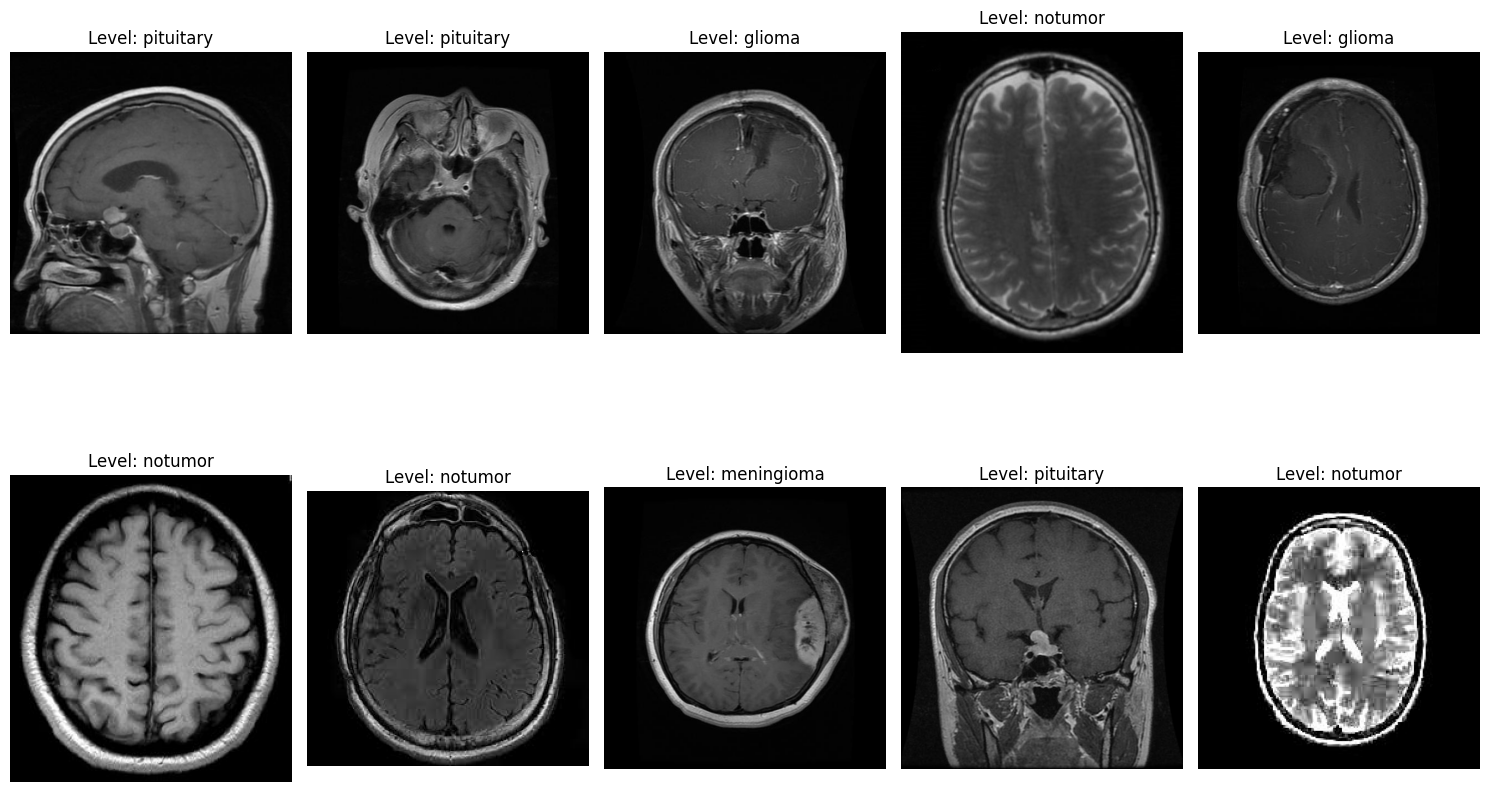

In [7]:
# prompt: show random 10 images with levels

import matplotlib.pyplot as plt

# Display 10 random images with their levels
plt.figure(figsize=(15, 10))
for i in range(10):
    index = random.randint(0, len(train_paths) - 1)
    img_path = train_paths[index]
    img_level = train_level[index]
    img = load_img(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Level: {img_level}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Image Preprocessing**

In [8]:
# Image Augmentation function
def augment_image(image):
    image = image.convert('RGB')  # Ensure RGB
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# **Model**

# WE ARE USING VGG16 FOR TRANSFER LEARNING

In [9]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_level, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1674s 6s/step - loss: 0.6577 - sparse_categorical_accuracy: 0.7340
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1431s 5s/step - loss: 0.2537 - sparse_categorical_accuracy: 0.9095
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1388s 5s/step - loss: 0.1832 - sparse_categorical_accuracy: 0.9320
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1386s 5s/step - loss: 0.1281 - sparse_categorical_accuracy: 0.9565
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1387s 5s/step - loss: 0.0791 - sparse_categorical_accuracy: 0.9726


# **Train and Val Plots**

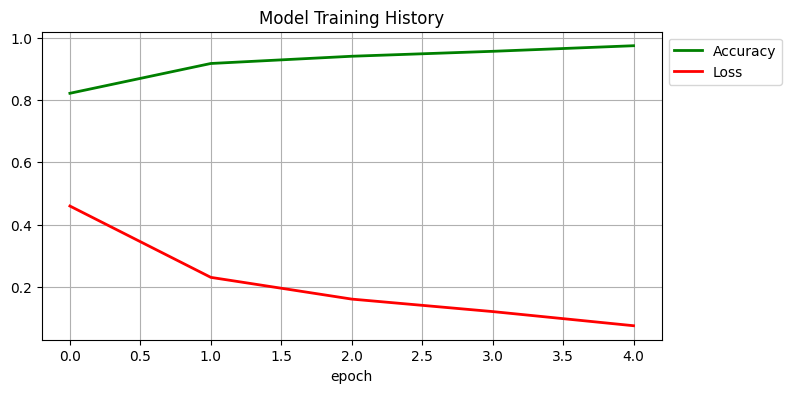

In [10]:
plt.figure(figsize=(8, 4))

plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'],'g-', linewidth=2)
plt.plot(history.history['loss'],'r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left',bbox_to_anchor=(1,1))
plt.show()

# **Model Classification Report**

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_level)

test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


42/42 ━━━━━━━━━━━━━━━━━━━━ 268s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       406
           1       0.90      0.96      0.93       300
           2       0.95      0.79      0.86       306
           3       0.88      0.98      0.93       301

    accuracy                           0.93      1313
   macro avg       0.93      0.93      0.93      1313
weighted avg       0.94      0.93      0.93      1313



# **Confission plot**

Confusion Matrix:
[[401   1   3   1]
 [  0 287   5   8]
 [  0  31 243  32]
 [  0   0   6 295]]


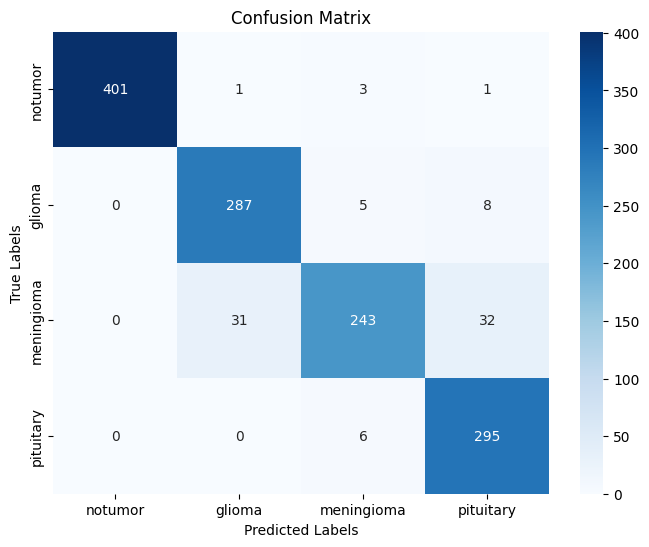

In [12]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# **Save and Load Model**

In [13]:

#save the entire model
model.save('model.h5')

In [14]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# **Tumor Detection**

In [16]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


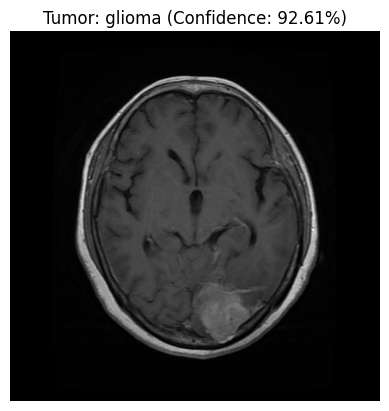

In [20]:
image_path = '/content/drive/MyDrive/Brain Tumor detection /MRI Images/Testing/meningioma/Te-me_0146.jpg'
detect_and_display(image_path, model)